# Nascent and Mature RNA quantification

Some biophysical models depend on both unspliced and spliced mRNA data, which can be obtained by quantifying nascent and mature RNA. We detail some of our own biophysical models here: https://biophysics.readthedocs.io/en/latest/

We output and AnnData object with spliced/unspliced layers, filter it based off of a UMI count threshold, and save it in the form of a loom object.

Notebook authored by Delaney K. Sullivan.

Please cite the following:

* Melsted P, Booeshaghi AS, Liu L, Gao F, Lu L, Min KHJ, et al. Modular, efficient and constant-memory single-cell RNA-seq preprocessing. Nat Biotechnol. 2021 Jul;39(7):813–8.

* Sullivan DK, Hjörleifsson KE, Swarna NP, Oakes C, Holley G, Melsted P, Pachter L. Accurate quantification of nascent and mature RNAs from single-cell and single-nucleus RNA-seq [Internet]. Nucleic Acids Research. 2025 Jan;53(1):gkae1137

* Sullivan DK, Min KH (Joseph), Hjörleifsson KE, Luebbert L, Holley G, Moses L, et al. kallisto, bustools, and kb-python for quantifying bulk, single-cell, and single-nucleus RNA-seq. Nat Protoc. 2025;20:587–607.

Note: The output can also be directly used in RNA velocity workflows. However, to read about some of our critiques of RNA velocity, please see the following publication:

* Gorin G, Fang M, Chari T, Pachter L. RNA velocity unraveled. PLoS Computational Biology. 18(9):e1010492.


## Setup

In [1]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

### Install python packages

In [2]:
%%time
!pip install --quiet scanpy python-igraph pybiomart
!pip install --quiet matplotlib
!pip install --quiet scikit-learn
!pip install --quiet numpy
!pip install --quiet scipy
!pip install --quiet loompy

!pip install --quiet kb-python==0.29.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.8/196.8

### Download the scRNA-seq data

Human week 10 fetal forebrain (10x2 single-cell) dataset (SRR6470906) subsetted to 50 million reads

In [2]:
%%time
!wget -q https://github.com/pachterlab/data/releases/download/v1/human_10x_R1.fastq.gz
!wget -q https://github.com/pachterlab/data/releases/download/v1/human_10x_R2.fastq.gz

CPU times: user 869 ms, sys: 144 ms, total: 1.01 s
Wall time: 1min 14s


## Downloading a pre-built index with kb ref

We download an index with --workflow=nac which includes the nascent and mature transcriptome.

If we were to build the index from scratch (given a reference FASTA and GTF), we'd run the following:

`kb ref -i index.idx -g t2g.txt --workflow=nac -f1 f1.fa -f2 f2.fa -c1 cdna.txt -c2 nascent.txt human_reference_path.fa human_gtf_path.gtf`





In [3]:
%%time
!kb ref --workflow=nac -d human -i index.idx -g t2g.txt -c1 cdna.txt -c2 nascent.txt

[2025-06-12 02:01:10,700]    INFO [download] Downloading files for human (nac workflow) from https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/v1/human_index_nac.tar.xz to tmp/human_index_nac.tar.xz
100%|██████████████████████████████████████| 1.84G/1.84G [00:45<00:00, 42.9MB/s]
[2025-06-12 02:01:56,631]    INFO [download] Extracting files from tmp/human_index_nac.tar.xz
CPU times: user 2.83 s, sys: 554 ms, total: 3.38 s
Wall time: 3min 48s


## Pseudoaligning the scRNA-seq data to the index with kb count

Note: We pseudoalign the reads using --workflow=nac which enables us to obtain nascent, mature, and ambiguous RNA classifications (in contrats, in our single-nucleus RNA-seq tutorial, we used a standard workflow for mapping reads to the nac index type because we didn't care about resolving nascent, mature, and ambiguous status).

In [6]:
%%time
# This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
!kb count -i index.idx -g t2g.txt -x 10XV2 --h5ad -t 2 --workflow=nac \
-c1 cdna.txt -c2 nascent.txt human_10x_R1.fastq.gz human_10x_R2.fastq.gz

[2025-06-12 02:09:36,391]    INFO [count_nac] Using index index.idx to generate BUS file to . from
[2025-06-12 02:09:36,392]    INFO [count_nac]         human_10x_R1.fastq.gz
[2025-06-12 02:09:36,392]    INFO [count_nac]         human_10x_R2.fastq.gz
[2025-06-12 02:25:34,972]    INFO [count_nac] Sorting BUS file ./output.bus to ./tmp/output.s.bus
[2025-06-12 02:25:47,403]    INFO [count_nac] On-list not provided
[2025-06-12 02:25:47,403]    INFO [count_nac] Copying pre-packaged 10XV2 on-list to .
[2025-06-12 02:25:47,483]    INFO [count_nac] Inspecting BUS file ./tmp/output.s.bus
[2025-06-12 02:25:51,092]    INFO [count_nac] Correcting BUS records in ./tmp/output.s.bus to ./tmp/output.s.c.bus with on-list ./10x_version2_whitelist.txt
[2025-06-12 02:25:59,310]    INFO [count_nac] Sorting BUS file ./tmp/output.s.c.bus to ./output.unfiltered.bus
[2025-06-12 02:26:08,945]    INFO [count_nac] Generating count matrix ./counts_unfiltered/cells_x_genes from BUS file ./output.unfiltered.bus
[20

## Setup python imports

In [171]:
import anndata
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
import sklearn

## Setup the AnnData matrix layers

First, the *cells x genes* matrices are imported into an H5AD-formatted [Anndata](https://icb-anndata.readthedocs-hosted.com/en/stable/anndata.AnnData.html) matrix. Anndata is a convenient format for storing single-cell count matrices in Python. It contains three layers: ambiguous, mature, and nascent.

We'll sum up the mature+ambiguous to be the 'spliced' layer and consider the nascent to be 'unspliced'.

In [153]:
# import data
adata = anndata.read_h5ad('counts_unfiltered/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 197056 × 39546
    layers: 'ambiguous', 'mature', 'nascent'

In [154]:
import numpy as np

# Create 'spliced' by summing 'mature' and 'ambiguous'
adata.layers['spliced'] = adata.layers['mature'] + adata.layers['ambiguous']
adata.X = adata.layers['spliced']

# Rename 'nascent' to 'unspliced'
adata.layers['unspliced'] = adata.layers['nascent']

# Delete the original layers
del adata.layers['mature']
del adata.layers['ambiguous']
del adata.layers['nascent']


# Make the 'ambiguous' layer contain nothing (since this layer usually isn't used)
adata.layers['ambiguous'] = np.zeros(adata.shape, dtype=adata.X.dtype)

In [155]:
adata

AnnData object with n_obs × n_vars = 197056 × 39546
    layers: 'spliced', 'unspliced', 'ambiguous'

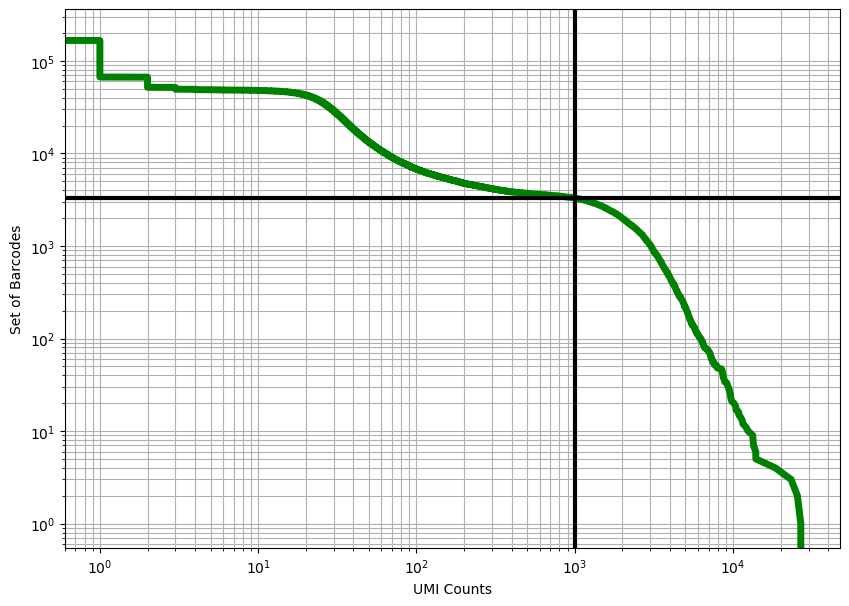

In [156]:
cutoff = 1000
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [157]:
# Compute the total spliced UMI count per cell
spliced_umis = np.array(adata.layers['spliced'].sum(axis=1)).flatten()

# Create a boolean mask for cells with > 1000 spliced UMIs
cell_mask = spliced_umis > 1000

# Subset the AnnData object
adata = adata[cell_mask]

## Save the final Anndata as a Loom file

In [158]:
adata.write_loom('final.loom')